In [21]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from tpot import TPOTClassifier
import itertools

In [2]:
model_data = pd.read_pickle('clean_added_data.pkl')

In [3]:
model_data.head()

,rate_avg,prescriptions_per_100,uninsured_2015,uninsured_2016,uninsured_2017,population_estimate,median age,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 20 to 24 years,Employment/Population Ratio; Estimate; AGE - 25 to 29 years,...,pop_native_american,pop_asian,pop_pac_islander,pop_ohter race,pop_two_more_races,county_state,prop_white,prop_black,prop_native_american,pop_other_race
0,1,129.6,0.128,0.134,0.110,55049.0,37.8,21.7,71.2,77.6,...,226,0.008066,0.000563,764,0.019564,"Autauga County, AL",0.768606,0.185217,0.004105,0.013879
1,0,123.8,0.158,0.175,0.161,199510.0,42.3,33.9,71.7,69.7,...,1355,0.006706,0.000000,1766,0.020129,"Baldwin County, AL",0.864323,0.093198,0.006792,0.008852
2,1,92.7,0.175,0.174,0.153,26614.0,38.7,14.6,46.7,45.7,...,46,0.004847,0.000000,1099,0.005786,"Barbour County, AL",0.467047,0.479297,0.001728,0.041294
3,1,97.2,0.151,0.150,0.136,22572.0,40.2,12.9,42.7,48.6,...,81,0.000620,0.000000,8,0.013778,"Bibb County, AL",0.769537,0.212121,0.003589,0.000354
4,1,56.9,0.183,0.176,0.165,57704.0,40.8,19.0,53.3,64.8,...,201,0.001594,0.000000,501,0.016151,"Blount County, AL",0.954405,0.015683,0.003483,0.008682


In [4]:
model_data.shape

(2517, 71)

In [5]:
model_data.isna().sum()

rate_avg                                                               0
prescriptions_per_100                                                  0
uninsured_2015                                                         0
uninsured_2016                                                         0
uninsured_2017                                                         0
population_estimate                                                    0
median age                                                             0
Employment/Population Ratio; Estimate; AGE - 16 to 19 years            0
Employment/Population Ratio; Estimate; AGE - 20 to 24 years            0
Employment/Population Ratio; Estimate; AGE - 25 to 29 years            0
Employment/Population Ratio; Estimate; AGE - 30 to 34 years            0
Employment/Population Ratio; Estimate; AGE - 35 to 44 years            0
Employment/Population Ratio; Estimate; AGE - 45 to 54 years            0
Employment/Population Ratio; Estimate; AGE - 55 to 

In [6]:
#split into X and y and scale X 
X = model_data.drop(['rate_avg', 'county_state'], axis=1)
y = model_data.rate_avg

X = pd.get_dummies(X)

cols = X.columns.tolist()
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Testing Models

###### Model Functions

In [7]:
def log_reg(X_train, X_test, y_train, y_test): 
    logreg = LogisticRegression(fit_intercept = False, C = 1e12) 

    model_log = logreg.fit(X_train, y_train)
    model_log
    y_hat_test = logreg.predict(X_test)
    y_hat_train = logreg.predict(X_train)
    residuals = y_train - y_hat_train
    print(pd.Series(residuals).value_counts())
    print(pd.Series(residuals).value_counts(normalize=True))

    residuals = y_test - y_hat_test
    print(pd.Series(residuals).value_counts())
    print(pd.Series(residuals).value_counts(normalize=True))

In [8]:
def rf_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state = 123))])

    # Set grid search params
    param_grid_forest = [ 
      {'clf__n_estimators': [100, 120],
       'clf__criterion': ['entropy', 'gini'], 
       'clf__max_depth': [4, 5, 6],  
       'clf__min_samples_leaf':[0.05 ,0.1, 0.2, 1, 2],  
       'clf__min_samples_split':[0.05 ,0.1, 0.2, 1.0, 2]
      }
    ]

    # Construct grid search
    gs_rf = GridSearchCV(estimator=pipe_rf,
                param_grid=param_grid_forest,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_rf.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_rf.best_score_)

    # Best params
    print('\nBest params:\n', gs_rf.best_params_)

In [9]:
def knn_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

    # Set grid search params
    knn_param_grid = {
        'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]
    }


    # Construct grid search
    gs_knn = GridSearchCV(estimator=pipe_knn,
                param_grid=knn_param_grid,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_knn.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_knn.best_score_)

    # Best params
    print('\nBest params:\n', gs_knn.best_params_)

In [10]:
def svm_gs(X_train, X_test, y_train, y_test):
    # Construct pipeline
    pipe_svm = Pipeline([('clf', svm.SVC(random_state=123))])

    # Set grid search params
    param_grid_svm = [
    #  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
      {'clf__C': [0.1, 1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf', 'linear']},
     ]

    # Construct grid search
    gs_svm = GridSearchCV(estimator=pipe_svm,
                param_grid=param_grid_svm,
                scoring='accuracy',
                cv=3, verbose=2, return_train_score = True)

    # Fit using grid search
    gs_svm.fit(X_train, y_train)

    # Best accuracy
    print('Best accuracy: %.3f' % gs_svm.best_score_)

    # Best params
    print('\nBest params:\n', gs_svm.best_params_)

In [11]:
def adaboost_gs(X_train, X_test, y_train, y_test):
    adaboost_clf = AdaBoostClassifier()

    adaboost_clf.fit(X_train, y_train)
    adaboost_train_preds = adaboost_clf.predict(X_train)
    adaboost_test_preds = adaboost_clf.predict(X_test)

    adaboost_train_score = accuracy_score(y_train, adaboost_train_preds)
    adaboost_test_score = accuracy_score(y_test, adaboost_test_preds)

    print('AdaBoosting')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(adaboost_train_score, adaboost_test_score))
    print("F1 Score: {}".format(f1_score(y_test, adaboost_test_preds, average='micro')))

In [12]:
def gb_gs(X_train, X_test, y_train, y_test):
    gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

    gb_clf.fit(X_train, y_train)
    gb_train_preds = gb_clf.predict(X_train)
    gb_test_preds = gb_clf.predict(X_test)

    gb_train_score = accuracy_score(y_train, gb_train_preds)
    gb_test_score = accuracy_score(y_test, gb_test_preds)

    print('Gradient Boosting')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(gb_train_score, gb_test_score))
    print("F1 Score: {}".format(f1_score(y_test, gb_test_preds, average='micro')))

In [13]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [14]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

###### No Resampling

Best model: SVM 

Best accuracy: 0.817 

Best params: 
 {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [16]:
log_reg(X_train, X_test, y_train, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    1465
 1     347
-1      75
Name: rate_avg, dtype: int64
 0    0.776365
 1    0.183890
-1    0.039746
Name: rate_avg, dtype: float64
 0    449
 1    141
-1     40
Name: rate_avg, dtype: int64
 0    0.712698
 1    0.223810
-1    0.063492
Name: rate_avg, dtype: float64


In [17]:
rf_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_sp

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_sp

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimator

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.5s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  4.5min finished


Best accuracy: 0.809

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [18]:
knn_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.1s
[CV] clf__n_neighbors=3 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    7.7s finished


In [19]:
svm_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   20.7s finished


In [40]:
# adaboost_gs(X_train, X_test, y_train, y_test)

In [23]:
gb_gs(X_train, X_test, y_train, y_test)

Gradient Boosting
Training Accuracy: 0.8256 		 Testing Accuracy: 0.7778
F1 Score: 0.7777777777777778


###### Downsampling

Best model: SVM 
    
Best accuracy: 0.796

Best params:
 {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_train_df = y_train.to_frame()

df_train = pd.concat([X_train, y_train_df], axis=1)

df_majority = df_train[df_train.rate_avg==1]
df_minority = df_train[df_train.rate_avg==0]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=513,  
                                 random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X_train = df_downsampled.drop(['rate_avg'], axis=1)
y_train = df_downsampled.rate_avg

In [25]:
log_reg(X_train, X_test, y_train, y_test)

 0    837
 1    128
-1     61
Name: rate_avg, dtype: int64
 0    0.815789
 1    0.124756
-1    0.059454
Name: rate_avg, dtype: float64
 0    446
 1    144
-1     40
Name: rate_avg, dtype: int64
 0    0.707937
 1    0.228571
-1    0.063492
Name: rate_avg, dtype: float64


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
rf_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_le

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_sample

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, cl

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=0.

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  3.0min finished


Best accuracy: 0.795

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 120}


In [27]:
knn_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] ............................... clf__n_neighbors=4, total=   0.0s
[CV] clf__n_neighbors=4 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.0s finished


In [28]:
svm_gs(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.0s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.1s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.3s finished


In [ ]:
# adaboost_gs(X_train, X_test, y_train, y_test)

In [29]:
gb_gs(X_train, X_test, y_train, y_test)

Gradient Boosting
Training Accuracy: 0.8743 		 Testing Accuracy: 0.7635
F1 Score: 0.7634920634920633


###### SMOTE

Best model: SVM 
    
Best accuracy: 0.865

Best params:
 {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [31]:
log_reg(X_resampled, X_test, y_resampled, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    2225
 1     406
-1     117
dtype: int64
 0    0.809680
 1    0.147744
-1    0.042576
dtype: float64
 0    435
 1    158
-1     37
Name: rate_avg, dtype: int64
 0    0.690476
 1    0.250794
-1    0.058730
Name: rate_avg, dtype: float64


In [32]:
rf_gs(X_resampled, X_test, y_resampled, y_test)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf_

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samp

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__m

[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=1, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=5, clf__min_samples_leaf=2, clf__mi

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_sa

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_l

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_sp

[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.7s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.8s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.8s
[CV] clf__criterion=entropy, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_spli

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.05, clf__min_samples_split=2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_s

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=0.2, clf__min_sa

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=0

[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimators=120, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=4, clf__min_samples_leaf=2, clf__min_samples_split=0.1, 

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.1, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.1, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=0.2, clf__min_sample

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=1, clf__min_samples_split=0.2, clf

[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=0.2, clf__n_estimators=120, total=   0.4s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=5, clf__min_samples_leaf=2, clf__min_samples_split=1.0, clf

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=100, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.05, clf__mi

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.1s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.3s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.1, clf__min_samples_sp

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=1.0, clf__n_estimators=120, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, clf__n_estimators=100, total=   0.2s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=0.2, clf__min_samples_split=2, c

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100, total=   0.5s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120 
[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s
[CV] clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=0.05, clf__n_estimator

[CV]  clf__criterion=gini, clf__max_depth=6, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=120, total=   0.6s


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  5.3min finished


Best accuracy: 0.836

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [33]:
knn_gs(X_resampled, X_test, y_resampled, y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................... clf__n_neighbors=1, total=   0.2s
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   0.1s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.2s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.2s
[CV] clf__n_neighbors=2 ..............................................
[CV] ............................... clf__n_neighbors=2, total=   0.2s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.2s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   0.2s
[CV] clf__n_neighbors=3 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   11.2s finished


In [34]:
svm_gs(X_resampled, X_test, y_resampled, y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   0.4s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=linear ................
[CV] . clf__C=0.1, clf__gamma=0.001, clf__kernel=linear, total=   0.2s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.3s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ..... clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf, total=   0.3s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   36.2s finished


Best accuracy: 0.873

Best params:
 {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


In [ ]:
# adaboost_gs(X_resampled, X_test, y_resampled, y_test)

In [35]:
gb_gs(X_resampled, X_test, y_resampled, y_test)

Gradient Boosting
Training Accuracy: 0.8861 		 Testing Accuracy: 0.781
F1 Score: 0.780952380952381


### Best model is SMOTE and SVM 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [37]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel = 'rbf', gamma = 0.01, C = 10)  
svclassifier.fit(X_resampled, y_resampled) 
y_pred = svclassifier.predict(X_test)
svclassifier.score(X_test, y_test)

0.7984126984126985

In [38]:
print_metrics(y_test, y_pred)

Precision Score: 0.8772727272727273
Recall Score: 0.840958605664488
Accuracy Score: 0.7984126984126985
F1 Score: 0.8587319243604005


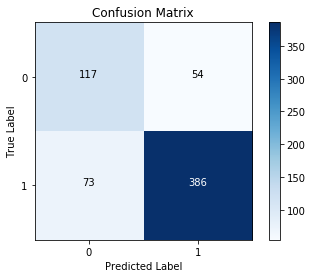

In [39]:
show_cf(y_test, y_pred)